<a href="https://colab.research.google.com/github/ormorteey/STA-237-Time-Series/blob/main/EDA_%26_Scalogram_STA_237_Project_%5BTime_Series_Anomaly_Detection_Using_Computer_Vision%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import skimage.measure
import pywt
import os

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%capture
%%R
# Signify cell is an R cell
# Silence Output

h = install.packages("pacman")
h = library(pacman)

In [ ]:
%%R
# load packages for data manipulation in R
p_load("tidyverse", "googledrive")

In [ ]:
# Silence Output
%%capture
%%R

# killing auth request
drive_deauth()
drive_user()

# retrieving fulll url ID of files
public_file = drive_get(as_id(c("10i8tM37aqHvD-YH2JK1qZAXzYdawIsgh","1eJ4uXiFqGqsXJ2ut5vex_Lg3BLlUAPjT","1B6pbF90ryhJ-kpu0nQ3FKt6RcSavgCMS")) )

# download the files
save_output = 1:3 %>% map(~drive_download(public_file[.,], overwrite = T))

In [ ]:
# file location for HDF5 & csv datasets
airbus_train_path = 'dftrain.h5'
airbus_valid_path = 'dfvalid.h5'
airbus_valid_groundtruth_path = 'dfvalid_groundtruth.csv'
# read hdf files: training data and validation data and ground truth [labels]
train_df = pd.read_hdf(airbus_train_path)
valid_df = pd.read_hdf(airbus_valid_path)
valid_groundtruth_df = pd.read_csv(airbus_valid_groundtruth_path)


In [ ]:
def prepare_dataset(df, rows = 10, cols = 10):
  
  # cast df as numpy array
  df_tensor = df.to_numpy()
  # reshape df to tensor to rows of df with 120 series with length 512
  df_tensor = np.reshape(df_tensor, (df.shape[0],120, 512))
  # diagnostics: shape of dataframe
  print(df.shape)
  # diagnostics: shape of df tensor
  print(df_tensor.shape)
  # get continuous wavelet transform scales
  SC_scales = np.array([2**(i/4) for i in range(1,65)])

  print(SC_scales.shape)

  # create empty scalograms
  df_scalograms = np.empty([rows, cols, 64, 64])
  # fill up scalogram
  for ii in np.arange(rows):
    for jj in np.arange(cols):   
      df_scalograms[ii,jj,:,:] =  get_scalogram(df_tensor[ii,jj], SC_scales)
  reshape_list = df_scalograms.shape
  print(df_scalograms.shape)
  df_scalograms = df_scalograms.reshape(reshape_list[0] * reshape_list[1], reshape_list[2], reshape_list[3], 1)

  return(df_scalograms)


In [ ]:
def get_scalogram(x, SC_scales):
  cwtmatr, freqs = pywt.cwt(x, SC_scales, 'mexh')
  a = skimage.measure.block_reduce(cwtmatr, (1,8), np.average)  
  return(a)

def scalogram_plotter(x, show = False):
  plt.imshow(x.reshape(64, 64), cmap = "jet", aspect = "auto")
  if show == True:
      plt.show()

# def prepare_labels(label_Arr, rows = None, cols = None ):

#   label_Arr = label_Arr.reshape([rows, 1])
#   label_Arr = label_Arr.reshape([rows, 1])
#   label_tensor = np.tile(label_Arr, cols).reshape([rows * cols, 1])
#   return(label_tensor)

In [ ]:
print(train_df.shape)
print(valid_df.shape)

(1677, 61440)
(594, 61440)


In [ ]:
# takes approximately 5 minutes for compute
with tf.device("/gpu:0"):
  rows, cols = 1677, 120
  validation_examples = prepare_dataset(valid_df, rows = 594, cols = 120)
  print(validation_examples.shape)
  train_examples = prepare_dataset(train_df, rows = 1677, cols = 120)
  print(train_examples.shape)

(594, 61440)
(594, 120, 512)
(64,)


In [ ]:
np.savez_compressed('', validation_examples, train_examples)

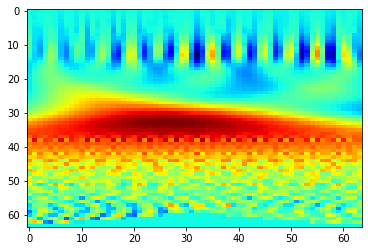

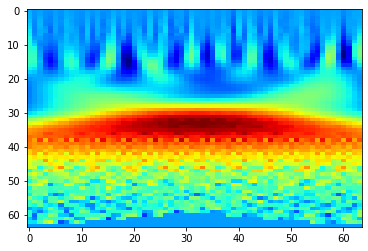

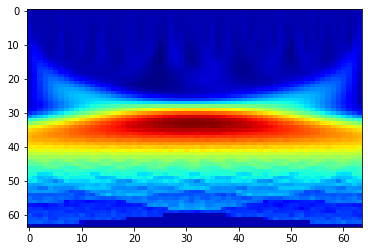

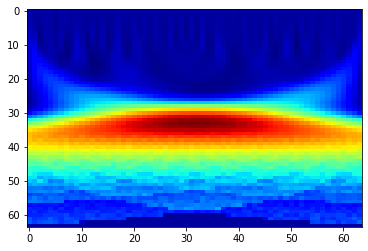

In [ ]:
scalogram_plotter(validation_examples[1,:,:,:],  True)
scalogram_plotter(validation_examples[0,:,:,:],  True)
# train examples
scalogram_plotter(train_examples[1,:,:,:],  True)
scalogram_plotter(train_examples[0,:,:,:],  True)

In [ ]:
# plot more random scalograms

# plt.figure(figsize= (10,10))
# rng = np.random.default_rng(12345)
# counter_list = [rng.integers(low=0, high=valid_tensor.shape[0]) for ii in np.arange(2)]

# for jj in np.arange(len(counter_list)):
#   ax = plt.subplot(2,1, jj + 1)
#   scalogram_plotter(valid_tensor[jj,:,:],  True)
#   plt.axis("off")

In [ ]:
# create labels

with tf.device("/gpu:0"):
  validation_labels = valid_groundtruth_df['anomaly'].head(594).to_numpy()
#   validation_labels = prepare_labels(validation_labels[:rows], rows, cols ).reshape(cols * rows)
#   print(validation_labels.shape)

  train_labels = np.ones([train_examples.shape[0]])
#   train_labels.shape

In [ ]:
# create dataset to serve the model
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
# validation_dataset = tf.data.Dataset.from_tensor_slices((validation_examples, validation_labels))

In [ ]:
# Configure dataset batch size and shuffler
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# train_dataset = train_dataset.batch(BATCH_SIZE)
# validation_dataset = validation_dataset.batch(BATCH_SIZE)

# Configuring dataset performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 64, 64, 1), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
# tf.data.experimental.save(
#     train_dataset, path = "/tr/", compression="GZIP", shard_func=None, checkpoint_args=None
# )

In [ ]:
tf.keras.backend.clear_session()
with tf.device("/gpu:0"):
  
  model = tf.keras.Sequential([
                         
    tf.keras.layers.InputLayer(input_shape = (64,64,1)),                          
    tf.keras.layers.Conv2D(64, kernel_size=2 , strides=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Conv2D(128, kernel_size=(2,2), strides=(2,2), activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Dense(32768,  activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Dense(300, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Dense(32768, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=1, strides=1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=2 , strides=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=2 , strides=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3))

  ])

with tf.device("/gpu:0"):
  model.compile(
    optimizer='adam',
    loss=tf.losses.MeanAbsoluteError())

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       32896     
                                                                 
 dense (Dense)               (None, 16, 16, 32768)     4227072   
                                                                 
 dense_1 (Dense)             (None, 16, 16, 300)       9830700   
                                                                 
 dense_2 (Dense)             (None, 16, 16, 32768)     9863168   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      4194432   
 nspose)                                                         
                                                        

In [ ]:

def resid_fn(pre_img, post_img):
  return(np.sum(np.absolute(pre_img - post_img)))
  

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# with tf.device("/gpu:0"):
with tf.device("/gpu:0"):
  model.fit(
    train_dataset,
    epochs=10
  )


Epoch 1/10
15/15 [==============================] - 130s 9s/step - loss: 0.6231
Epoch 2/10
15/15 [==============================] - 129s 9s/step - loss: 0.1389
Epoch 3/10
15/15 [==============================] - 129s 9s/step - loss: 0.0736
Epoch 4/10
15/15 [==============================] - 130s 9s/step - loss: 0.0426
Epoch 5/10
15/15 [==============================] - 129s 9s/step - loss: 0.0727
Epoch 6/10
15/15 [==============================] - 130s 9s/step - loss: 0.0681
Epoch 7/10
15/15 [==============================] - 129s 9s/step - loss: 0.0367
Epoch 8/10
15/15 [==============================] - 129s 9s/step - loss: 0.0324
Epoch 9/10
15/15 [==============================] - 127s 8s/step - loss: 0.0343
Epoch 10/10
13/15 [=========================>....] - ETA: 16s - loss: 0.0265

In [ ]:
def classificator(validation_examples, train_examples, rows, cols, qtl = 0.99, model = None):
  post_validation_exam = model.predict(validation_examples)
  # post = train_examples = model.predict(train_examples)
  cutoff = get_train_residuals_qtl(train_examples, qtl, model)
  res = []
  temp_res = []
  for ii in range(0,rows * cols, cols):
    print("===== Done {} out of {}".format(ii, rows) )
    for jj in range(cols):
      temp_res.append(resid_fn(validation_examples[ii+jj,:, :,:], post_validation_exam[ii+jj,:,:,:]))
    
    if max(temp_res) > cutoff:
      res.append(1)
    else:
      res.append(0) 

  return(res) 



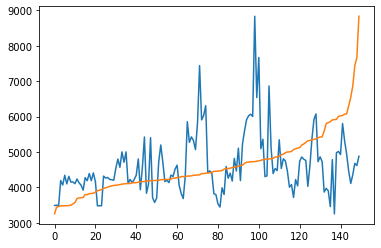

In [ ]:
 pred_train = get_train_residuals_qtl(train_examples, qtl = 0.99, model = model)

In [ ]:
pred_train

7665.473265628503

In [ ]:
def get_train_residuals_qtl(train_examples, qtl = 0.99, model = None):
  
  results = []
  res = model.predict(train_examples)
  for ii in range(rows*cols):
    results.append( resid_fn(res[ii,:,:,:], train_examples[ii,:,:,:]))
  plt.plot(results)
  results.sort()
  plt.plot(results)  
  return(results[int(np.floor(len(results) * qtl))])
  # return(results)


In [ ]:
with tf.device("/gpu:0"):
  pred_labels = classificator(validation_examples, train_examples, rows, cols, qtl = 0.9, model = model)

In [ ]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

21

In [ ]:
validation_labels

array([0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.])